# Regularization and Evaluation of Neural Networks

<a href="https://colab.research.google.com/github/flatiron-school/NTL01-DTSC-LIVE-040323/blob/main/4phase/63-network_regularization_and_evaluation.ipynb" 
target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from tensorflow.keras.models import Sequential

In [9]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision

from scikeras.wrappers import KerasClassifier

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# !pip install scikeras

In [11]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [73]:
### we load the data .astype('float32') to save memory and gain computational speed

In [74]:
# same low-res grayscale images of digits 0-9
digits = load_digits()
X = digits.data.astype('float32')
y = digits.target.astype('float32')

y_binary = y % 2

In [75]:
X[0]  # this is the "float32" output

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.],
      dtype=float32)

In [70]:
# (64,) vector of bits for a grayscale image
X[0]  # this is the "float64" output

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [15]:
# from tensorflow.keras.models import Sequential

# instantiate the model
model = Sequential()

# add our first hidden layer with 12 nodes, 'relu' (on/off) activaction function, dimensions must be (64,)
model.add(Dense(12, activation='relu', input_dim=64))

# add a second hidden layer with 8 nodes, same activation
model.add(Dense(8, activation='relu'))

# output layer, one node, activation is sigmoid because we are performing binary classification
model.add(Dense(1, activation='sigmoid'))


# The next step is new: After building the model we'll now **compile** it, which is a matter of yoking together 
# the architecture with:
# - the optimizer we want to use, the loss function we want to use, and the metrics (can be multiple) we want to use.

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# the data in fit need to be np.arrays, NOT PANDAS DF's
model.fit(X, y_binary, epochs=50, batch_size=10)

Epoch 1/50
180/180 [==============================] - 1s 2ms/step - loss: 0.6592 - accuracy: 0.6344
Epoch 2/50
180/180 [==============================] - 0s 2ms/step - loss: 0.4957 - accuracy: 0.8258
Epoch 3/50
180/180 [==============================] - 0s 2ms/step - loss: 0.3343 - accuracy: 0.8859
Epoch 4/50
180/180 [==============================] - 0s 2ms/step - loss: 0.2498 - accuracy: 0.9043
Epoch 5/50
180/180 [==============================] - 0s 2ms/step - loss: 0.1991 - accuracy: 0.9265
Epoch 6/50
180/180 [==============================] - 0s 2ms/step - loss: 0.1705 - accuracy: 0.9338
Epoch 7/50
180/180 [==============================] - 0s 2ms/step - loss: 0.1481 - accuracy: 0.9438
Epoch 8/50
180/180 [==============================] - 0s 2ms/step - loss: 0.1327 - accuracy: 0.9488
Epoch 9/50
180/180 [==============================] - 0s 2ms/step - loss: 0.1200 - accuracy: 0.9555
Epoch 10/50
180/180 [==============================] - 0s 2ms/step - loss: 0.1109 - accuracy: 0.9577

# IMPORTANT

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling

**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

# SAME IDEA, IMPORTANT

## SCALING FOR SPEED
Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [77]:
# SPLIT ON THE WHOLE DATA SET
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

# SECONDARY SPLIT ON THE TRAIN DATA!!!! provides additional layer to validate against
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)


# scaling the data in min/max fashion. BECAUSE min value is zero the operation is just x/max_val, ergo... /16
# so all data will be scaled between 0 and 1 for this secondary validation set
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [78]:
# some lack of clarity on the exact import statement required
# from tensorflow.keras.models import Sequential

model = Sequential()

# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.7294 - accuracy: 0.5039
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.7222 - accuracy: 0.5039
Epoch 3/10
12/12 [==============================] - 0s 1ms/step - loss: 0.7165 - accuracy: 0.5039
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.7116 - accuracy: 0.5039
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.7082 - accuracy: 0.5039
Epoch 6/10
12/12 [==============================] - 0s 1ms/step - loss: 0.7055 - accuracy: 0.5039
Epoch 7/10
12/12 [==============================] - 0s 1ms/step - loss: 0.7032 - accuracy: 0.5039
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.7015 - accuracy: 0.5039
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.7002 - accuracy: 0.5039
Epoch 10/10
12/12 [==============================] - 0s 1ms/step - loss: 0.6992 - accuracy: 0.5039


We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [81]:
# this is a huge list of hyperparameters and data types, not very useful atm
# model.__dict__

In [82]:
# results is the actual fitting of the model, and returns the dictionary of the loss and all metrics
results.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x7f8994566fa0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.729411780834198,
   0.7222234010696411,
   0.7165136933326721,
   0.7116323709487915,
   0.7082113027572632,
   0.7055414915084839,
   0.7032096982002258,
   0.701483964920044,
   0.7002209424972534,
   0.6991596221923828],
  'accuracy': [0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [84]:
# will be used for the x values of plotting in the next cell, final key of the results.__dict__ above
results.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

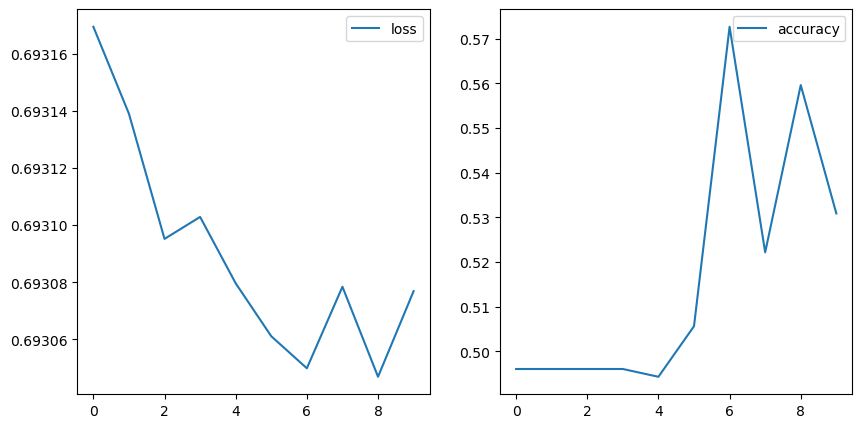

In [19]:
# Dictionary indexing into data, the key is 'loss' and the value is the list of 10 loss scores for each epoch
sigmoid_loss = results.history['loss']

# Dictionary entry containing 10 epoch's accuracy scores
sigmoid_accuracy = results.history['accuracy']

# plot with 1 row, 2 columns, 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

In [20]:
X_pure_train.shape[0]

1149

In [88]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer="SGD",
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=None, verbose=1)

# batch_size= None defaults to 32, so even though we didnt specify a value, the batch size is actually smaller

Epoch 1/100
36/36 [==============================] - 0s 1ms/step - loss: 0.6844 - accuracy: 0.5909
Epoch 2/100
36/36 [==============================] - 0s 1ms/step - loss: 0.6816 - accuracy: 0.6197
Epoch 3/100
36/36 [==============================] - 0s 1ms/step - loss: 0.6783 - accuracy: 0.6519
Epoch 4/100
36/36 [==============================] - 0s 1ms/step - loss: 0.6745 - accuracy: 0.6754
Epoch 5/100
36/36 [==============================] - 0s 1ms/step - loss: 0.6701 - accuracy: 0.6876
Epoch 6/100
36/36 [==============================] - 0s 1ms/step - loss: 0.6651 - accuracy: 0.6989
Epoch 7/100
36/36 [==============================] - 0s 1ms/step - loss: 0.6594 - accuracy: 0.7145
Epoch 8/100
36/36 [==============================] - 0s 1ms/step - loss: 0.6528 - accuracy: 0.7276
Epoch 9/100
36/36 [==============================] - 0s 1ms/step - loss: 0.6452 - accuracy: 0.7346
Epoch 10/100
36/36 [==============================] - 0s 1ms/step - loss: 0.6367 - accuracy: 0.7450
Epoch 11/

36/36 [==============================] - 0s 1ms/step - loss: 0.1927 - accuracy: 0.9156
Epoch 84/100
36/36 [==============================] - 0s 1ms/step - loss: 0.1925 - accuracy: 0.9173
Epoch 85/100
36/36 [==============================] - 0s 1ms/step - loss: 0.1921 - accuracy: 0.9156
Epoch 86/100
36/36 [==============================] - 0s 1ms/step - loss: 0.1897 - accuracy: 0.9164
Epoch 87/100
36/36 [==============================] - 0s 1ms/step - loss: 0.1904 - accuracy: 0.9191
Epoch 88/100
36/36 [==============================] - 0s 1ms/step - loss: 0.1885 - accuracy: 0.9208
Epoch 89/100
36/36 [==============================] - 0s 1ms/step - loss: 0.1882 - accuracy: 0.9199
Epoch 90/100
36/36 [==============================] - 0s 1ms/step - loss: 0.1869 - accuracy: 0.9208
Epoch 91/100
36/36 [==============================] - 0s 1ms/step - loss: 0.1866 - accuracy: 0.9182
Epoch 92/100
36/36 [==============================] - 0s 1ms/step - loss: 0.1868 - accuracy: 0.9199
Epoch 93/100


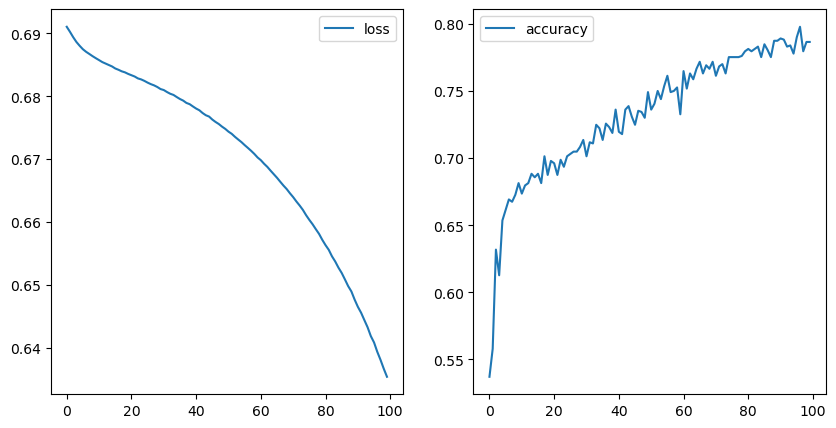

In [22]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Epoch 1/30
115/115 [==============================] - 0s 1ms/step - loss: 0.9160 - accuracy: 0.5257
Epoch 2/30
115/115 [==============================] - 0s 1ms/step - loss: 1.0309 - accuracy: 0.4935
Epoch 3/30
115/115 [==============================] - 0s 1ms/step - loss: 0.9532 - accuracy: 0.5117
Epoch 4/30
115/115 [==============================] - 0s 1ms/step - loss: 0.9356 - accuracy: 0.5117
Epoch 5/30
115/115 [==============================] - 0s 1ms/step - loss: 1.0310 - accuracy: 0.5048
Epoch 6/30
115/115 [==============================] - 0s 1ms/step - loss: 0.9893 - accuracy: 0.4970
Epoch 7/30
115/115 [==============================] - 0s 1ms/step - loss: 1.0744 - accuracy: 0.4708
Epoch 8/30
115/115 [==============================] - 0s 1ms/step - loss: 1.0847 - accuracy: 0.4665
Epoch 9/30
115/115 [==============================] - 0s 1ms/step - loss: 1.0392 - accuracy: 0.4970
Epoch 10/30
115/115 [==============================] - 0s 1ms/step - loss: 0.9893 - accuracy: 0.4970

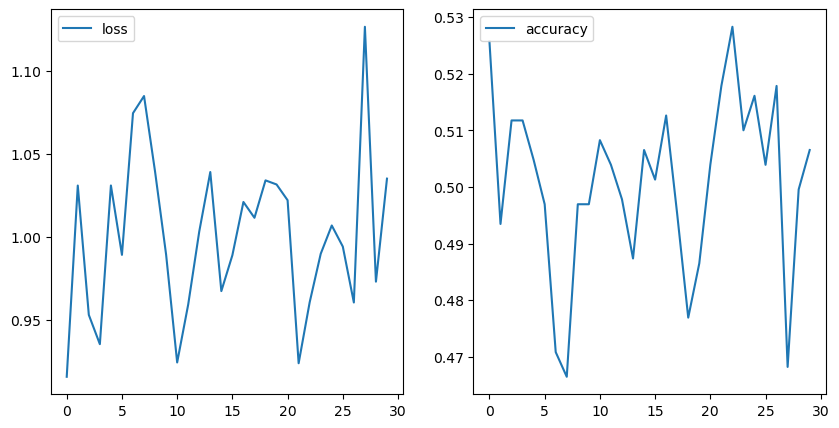

In [92]:
model = Sequential()

# sgd = SGD(learning_rate=9)
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# this time, SGD is not in " " like a string... IN ORDER TO SET A MANUAL LEARNING RATE
# Otherwise, default value of learning rate is .01, so this is a TOO-LARGE learning rate, causing us to overshoot local
# minimum of loss function gradient, bouncing around the minimum values, 
# even with some randomness, the plots still look very herky jerky
model.compile(optimizer=SGD(learning_rate=9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy');

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

# SAME MODEL SETUP AS BEFORE, DIFFERENT OPTIMIZER

In [93]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# "adam" optimizer for no particular reason
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# SAME ASSIGNMENT OF THE FITTING FOR LATER DICTIONARY ACCESS
### NEW ARGUMENTS PASSED IN THE FITTING THOUGH!!!!!
### validation_data = (X_val, y_val) from the second train/test split

In [94]:
results = model.fit(X_pure_train, y_pure_train,
                   validation_data=(X_val, y_val),
                   epochs=30, batch_size=10)

Epoch 1/30
115/115 [==============================] - 1s 3ms/step - loss: 0.6439 - accuracy: 0.7084 - val_loss: 0.5749 - val_accuracy: 0.8229
Epoch 2/30
115/115 [==============================] - 0s 2ms/step - loss: 0.4519 - accuracy: 0.8520 - val_loss: 0.3730 - val_accuracy: 0.8611
Epoch 3/30
115/115 [==============================] - 0s 2ms/step - loss: 0.3141 - accuracy: 0.8816 - val_loss: 0.2982 - val_accuracy: 0.8819
Epoch 4/30
115/115 [==============================] - 0s 2ms/step - loss: 0.2603 - accuracy: 0.8956 - val_loss: 0.2796 - val_accuracy: 0.8993
Epoch 5/30
115/115 [==============================] - 0s 2ms/step - loss: 0.2274 - accuracy: 0.9086 - val_loss: 0.2422 - val_accuracy: 0.9097
Epoch 6/30
115/115 [==============================] - 0s 2ms/step - loss: 0.2034 - accuracy: 0.9164 - val_loss: 0.2170 - val_accuracy: 0.9167
Epoch 7/30
115/115 [==============================] - 0s 2ms/step - loss: 0.1895 - accuracy: 0.9225 - val_loss: 0.2042 - val_accuracy: 0.9271
Epoch 

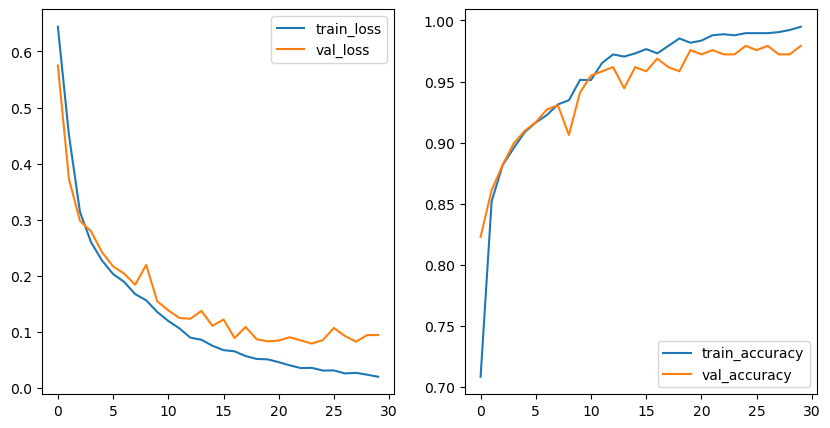

In [95]:
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
results = model.fit(X_pure_train, y_pure_train,
                   validation_data=(X_val, y_val),
                   epochs=30, batch_size=10)
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [103]:
results.history['accuracy'][-5:], "____________", results.history['val_accuracy'][-5:]

([0.9895561337471008,
  0.9895561337471008,
  0.9904264807701111,
  0.9921671152114868,
  0.9947780966758728],
 '____________',
 [0.9756944179534912,
  0.9791666865348816,
  0.9722222089767456,
  0.9722222089767456,
  0.9791666865348816])

# THESE ARE TEST/TRAIN ACCURACY SCORES FOR FINAL EPOCH

In [97]:
results.history['val_accuracy'][-1]

0.9791666865348816

In [98]:
results.history['accuracy'][-1]

0.9947780966758728

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [29]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x7f899360ee20> does not.

# IMPORTANT

### function to be used as part of wrapper to add sckit functionality

In [30]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [31]:
# from scikeras.wrappers import KerasClassifier

keras_model = KerasClassifier(build_model,
                                          epochs=50,
                                          batch_size=32,
                                          verbose=2)

### can add "validation_split=.2,  in the cell above here...
check completed notebook

In [106]:
type(build_model)

function

In [104]:
type(model)

keras.engine.sequential.Sequential

In [105]:
type(keras_model)

scikeras.wrappers.KerasClassifier

# Here we can do the cross_val_score after using a wrapper

In [33]:
cross_val_score(keras_model, X_pure_train, y_pure_train)

Epoch 1/50
29/29 - 1s - loss: 0.6933 - accuracy: 0.4908 - 613ms/epoch - 21ms/step
Epoch 2/50
29/29 - 0s - loss: 0.6897 - accuracy: 0.6061 - 59ms/epoch - 2ms/step
Epoch 3/50
29/29 - 0s - loss: 0.6810 - accuracy: 0.5386 - 75ms/epoch - 3ms/step
Epoch 4/50
29/29 - 0s - loss: 0.6602 - accuracy: 0.6779 - 73ms/epoch - 3ms/step
Epoch 5/50
29/29 - 0s - loss: 0.6228 - accuracy: 0.7943 - 71ms/epoch - 2ms/step
Epoch 6/50
29/29 - 0s - loss: 0.5744 - accuracy: 0.8259 - 49ms/epoch - 2ms/step
Epoch 7/50
29/29 - 0s - loss: 0.5225 - accuracy: 0.8411 - 45ms/epoch - 2ms/step
Epoch 8/50
29/29 - 0s - loss: 0.4712 - accuracy: 0.8520 - 74ms/epoch - 3ms/step
Epoch 9/50
29/29 - 0s - loss: 0.4216 - accuracy: 0.8694 - 83ms/epoch - 3ms/step
Epoch 10/50
29/29 - 0s - loss: 0.3795 - accuracy: 0.8716 - 77ms/epoch - 3ms/step
Epoch 11/50
29/29 - 0s - loss: 0.3425 - accuracy: 0.8825 - 69ms/epoch - 2ms/step
Epoch 12/50
29/29 - 0s - loss: 0.3160 - accuracy: 0.8868 - 74ms/epoch - 3ms/step
Epoch 13/50
29/29 - 0s - loss: 0.29

Epoch 2/50
29/29 - 0s - loss: 0.6922 - accuracy: 0.4962 - 44ms/epoch - 2ms/step
Epoch 3/50
29/29 - 0s - loss: 0.6902 - accuracy: 0.5593 - 58ms/epoch - 2ms/step
Epoch 4/50
29/29 - 0s - loss: 0.6858 - accuracy: 0.5941 - 53ms/epoch - 2ms/step
Epoch 5/50
29/29 - 0s - loss: 0.6774 - accuracy: 0.6083 - 56ms/epoch - 2ms/step
Epoch 6/50
29/29 - 0s - loss: 0.6634 - accuracy: 0.6583 - 46ms/epoch - 2ms/step
Epoch 7/50
29/29 - 0s - loss: 0.6441 - accuracy: 0.6605 - 48ms/epoch - 2ms/step
Epoch 8/50
29/29 - 0s - loss: 0.6205 - accuracy: 0.6921 - 47ms/epoch - 2ms/step
Epoch 9/50
29/29 - 0s - loss: 0.5944 - accuracy: 0.7628 - 51ms/epoch - 2ms/step
Epoch 10/50
29/29 - 0s - loss: 0.5675 - accuracy: 0.7748 - 52ms/epoch - 2ms/step
Epoch 11/50
29/29 - 0s - loss: 0.5415 - accuracy: 0.8096 - 57ms/epoch - 2ms/step
Epoch 12/50
29/29 - 0s - loss: 0.5190 - accuracy: 0.7954 - 41ms/epoch - 1ms/step
Epoch 13/50
29/29 - 0s - loss: 0.4884 - accuracy: 0.8433 - 43ms/epoch - 1ms/step
Epoch 14/50
29/29 - 0s - loss: 0.455

Epoch 3/50
29/29 - 0s - loss: 0.6855 - accuracy: 0.6533 - 70ms/epoch - 2ms/step
Epoch 4/50
29/29 - 0s - loss: 0.6778 - accuracy: 0.6696 - 59ms/epoch - 2ms/step
Epoch 5/50
29/29 - 0s - loss: 0.6651 - accuracy: 0.6739 - 68ms/epoch - 2ms/step
Epoch 6/50
29/29 - 0s - loss: 0.6462 - accuracy: 0.7293 - 66ms/epoch - 2ms/step
Epoch 7/50
29/29 - 0s - loss: 0.6212 - accuracy: 0.7543 - 69ms/epoch - 2ms/step
Epoch 8/50
29/29 - 0s - loss: 0.5907 - accuracy: 0.7891 - 58ms/epoch - 2ms/step
Epoch 9/50
29/29 - 0s - loss: 0.5539 - accuracy: 0.8076 - 44ms/epoch - 2ms/step
Epoch 10/50
29/29 - 0s - loss: 0.5140 - accuracy: 0.8326 - 66ms/epoch - 2ms/step
Epoch 11/50
29/29 - 0s - loss: 0.4710 - accuracy: 0.8554 - 50ms/epoch - 2ms/step
Epoch 12/50
29/29 - 0s - loss: 0.4267 - accuracy: 0.8793 - 57ms/epoch - 2ms/step
Epoch 13/50
29/29 - 0s - loss: 0.3875 - accuracy: 0.8783 - 61ms/epoch - 2ms/step
Epoch 14/50
29/29 - 0s - loss: 0.3489 - accuracy: 0.8870 - 52ms/epoch - 2ms/step
Epoch 15/50
29/29 - 0s - loss: 0.32

array([0.94782609, 0.91304348, 0.93043478, 0.93913043, 0.88646288])

In [34]:
# David is going to look into scoring this later for test data
keras_model

KerasClassifier(
	model=<function build_model at 0x7f898d98bb80>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=2
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	class_weight=None
)

In [35]:
# generally adding validation data as a hyperparameter 
# is better than cross val score

## Regularization

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

# L2 regulariztion applied to only 1 layer of the model

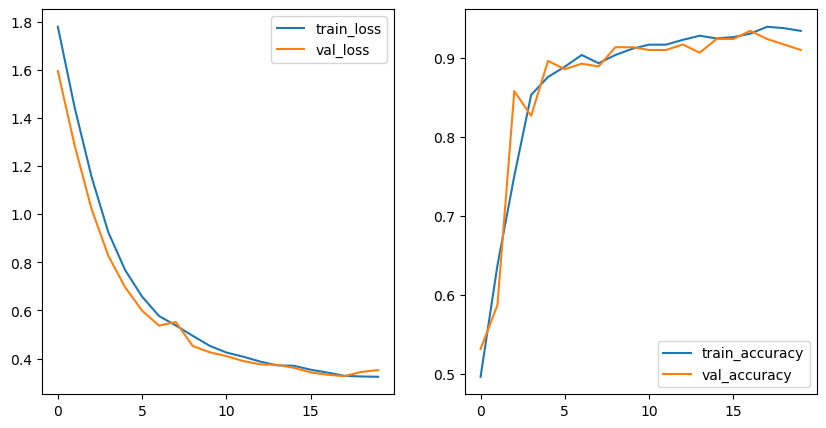

In [36]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

# kernel_reg is where you add the regularization
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

# Adding L2 REGULARIZATION to multiple layers:

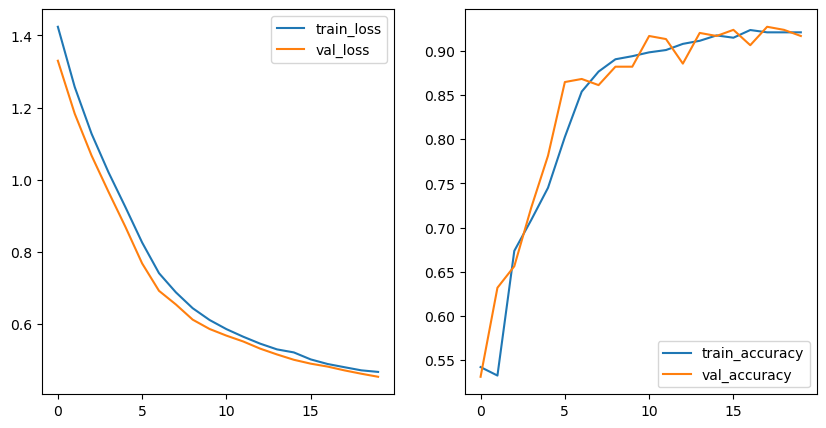

In [37]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

# SO THERE CAN BE TOOOOOO MUCH REGULARIZATION, just pay attention

# NEXT..........

# DROPOUT REGULARIZATION

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

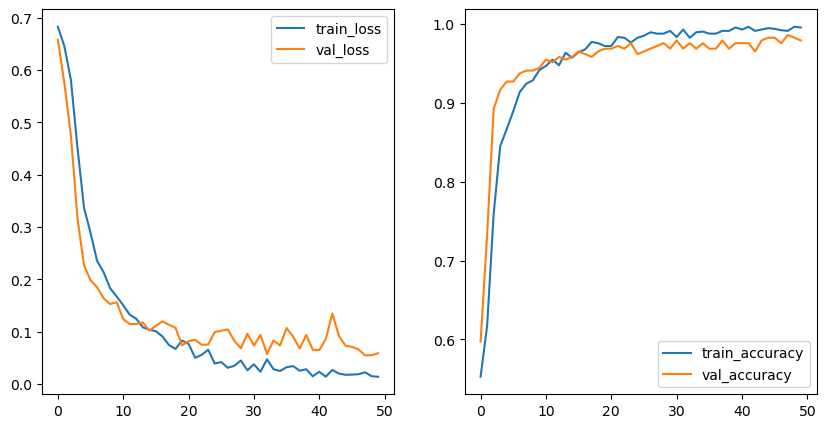

In [107]:
# model.add(Dropout(0.5))

model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))

# DROPOUT -> percentage of the inputs to be randomly dropped, training = <Bool> also important
# if training=True (default), then dropouts will occur, if False, dropouts will not occur
# this will be applied to the Dense layer of 20 nodes that precedes this code
model.add(Dropout(0.5))

model.add(Dense(12, activation='relu'))

# another dropout for above layer
model.add(Dropout(0.2))

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# VERBOSE SET TO '0' this time!!!!!
results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))








train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [108]:
results.history['val_accuracy'][-1]

0.9791666865348816

In [109]:
results.history['accuracy'][-1]

0.9956483840942383

# NEXT........

### EARLY STOPPING AS A FORM OF REGULARIZATION TO PREVENT OVERFITTING

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

Epoch 1/20
36/36 [==============================] - 1s 11ms/step - loss: 0.6933 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.4688
Epoch 2/20
36/36 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6934 - val_accuracy: 0.4688
Epoch 2: early stopping


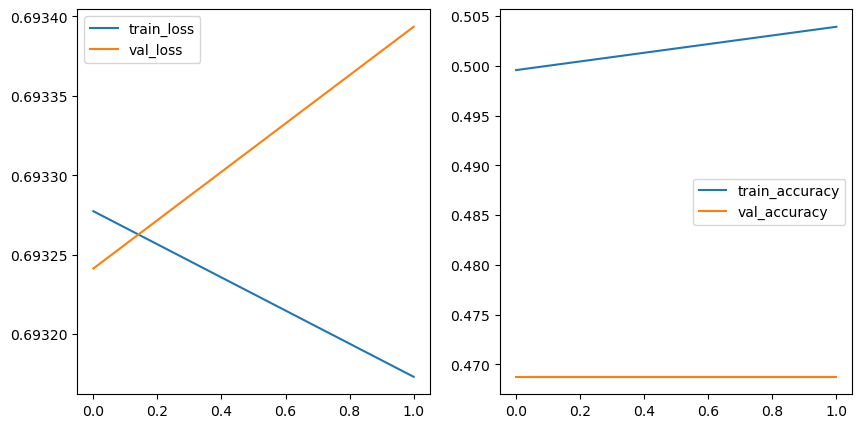

In [41]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-4,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=1, validation_data=(X_val, y_val),
                    callbacks=[early_stop]) # must be list, but can be multiple

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

Epoch 38: early stopping


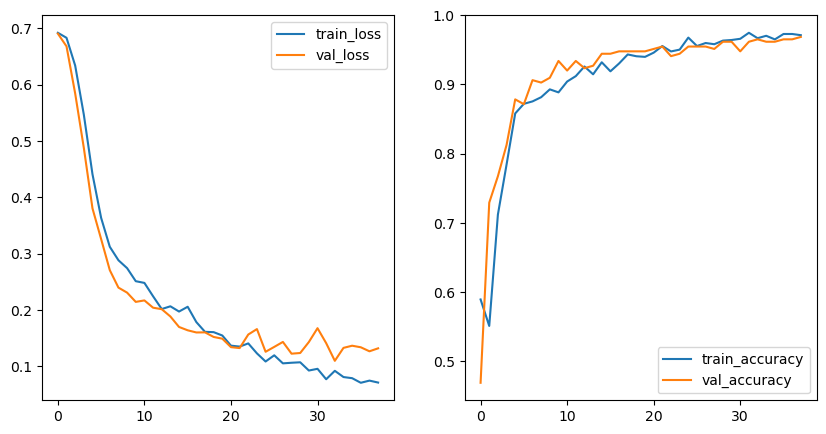

In [42]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1, 
                           patience=5,  # this IS important
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object



# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [43]:
results.history['val_accuracy'][-1]

0.96875

In [44]:
results.history['accuracy'][-1]

0.9712793827056885

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

# SAME DATA, same 3 level split, SAME MIN-MAX Scaling

In [117]:
digits = load_digits()
X = digits.data
y = digits.target

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

# BUT.......

For a multiclass output, our neural net expects our target to be in a certain form.

### This means that they want our target values to have n rows of labels, and c columns for each class

# IMPORTANT

In [119]:
y_test[0]

6

In [120]:
ohe = OneHotEncoder(sparse_output=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [121]:
y_test.shape

(360, 10)

In [122]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

# 10 output neurons because we are producing values 0-9

### EXPLANATION BELOW THIS CELL...

In [52]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))

# ACTIVATION FUNCTION OF SOFTMAX FOR MULTINOMIAL PREDICTION/MULTICLASS CLASSIFICATION
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision()])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50
115/115 [==============================] - 1s 5ms/step - loss: 2.2619 - accuracy: 0.1549 - precision: 0.0000e+00 - val_loss: 2.1734 - val_accuracy: 0.2674 - val_precision: 0.0000e+00
Epoch 2/50
115/115 [==============================] - 0s 3ms/step - loss: 2.0482 - accuracy: 0.3681 - precision: 0.0000e+00 - val_loss: 1.9553 - val_accuracy: 0.3785 - val_precision: 0.0000e+00
Epoch 3/50
115/115 [==============================] - 0s 3ms/step - loss: 1.7715 - accuracy: 0.4369 - precision: 1.0000 - val_loss: 1.6426 - val_accuracy: 0.5035 - val_precision: 1.0000
Epoch 4/50
115/115 [==============================] - 0s 3ms/step - loss: 1.4390 - accuracy: 0.5883 - precision: 0.9789 - val_loss: 1.3203 - val_accuracy: 0.6319 - val_precision: 1.0000
Epoch 5/50
115/115 [==============================] - 0s 3ms/step - loss: 1.1452 - accuracy: 0.7311 - precision: 0.9834 - val_loss: 1.0583 - val_accuracy: 0.7396 - val_precision: 1.0000
Epoch 6/50
115/115 [==============================] - 

Epoch 45/50
115/115 [==============================] - 0s 3ms/step - loss: 0.0932 - accuracy: 0.9774 - precision: 0.9799 - val_loss: 0.1417 - val_accuracy: 0.9549 - val_precision: 0.9677
Epoch 46/50
115/115 [==============================] - 0s 3ms/step - loss: 0.0878 - accuracy: 0.9791 - precision: 0.9851 - val_loss: 0.1574 - val_accuracy: 0.9444 - val_precision: 0.9607
Epoch 47/50
115/115 [==============================] - 0s 3ms/step - loss: 0.0868 - accuracy: 0.9774 - precision: 0.9824 - val_loss: 0.1558 - val_accuracy: 0.9410 - val_precision: 0.9537
Epoch 48/50
115/115 [==============================] - 0s 2ms/step - loss: 0.0832 - accuracy: 0.9791 - precision: 0.9842 - val_loss: 0.1357 - val_accuracy: 0.9549 - val_precision: 0.9611
Epoch 49/50
115/115 [==============================] - 0s 2ms/step - loss: 0.0874 - accuracy: 0.9809 - precision: 0.9833 - val_loss: 0.1370 - val_accuracy: 0.9514 - val_precision: 0.9677
Epoch 50/50
115/115 [==============================] - 0s 2ms/ste

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [53]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

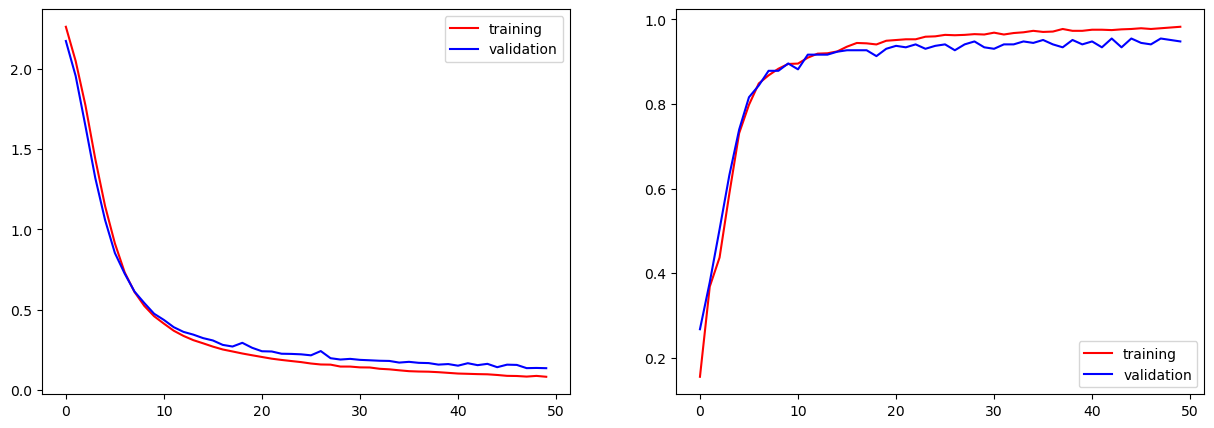

In [54]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)
ax1.legend();

In [55]:
y_hat_test = np.argmax(model.predict(X_test), axis=-1)

12/12 [==============================] - 0s 2ms/step


### The model.predict returns the probability for each possible class, and the sum of these probabilites is 1

In [57]:
model.predict(X_test)[0]

12/12 [==============================] - 0s 1ms/step


array([5.22707868e-03, 1.17824646e-04, 5.73573757e-08, 8.33880222e-07,
       9.01007006e-05, 1.47977305e-04, 9.93671656e-01, 2.29754896e-05,
       4.84095624e-04, 2.37368789e-04], dtype=float32)

In [124]:
y_test[:5]  # y_test = ohe.transform(y_test.reshape(-1,1))

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [125]:
# conversion back to original data
ohe.inverse_transform(y_test)[:5]

array([[6],
       [9],
       [3],
       [7],
       [2]])

In [126]:
# converts the data back to its original form...
y_test_restore = ohe.inverse_transform(y_test)
confusion_matrix(y_test_restore, y_hat_test)  # y_hat_test = np.argmax(model.predict(X_test), axis=-1)

# y_hat_test is the maximum value (probability) in a row of 10 values, 1 for each class

array([[31,  0,  0,  0,  1,  0,  1,  0,  0,  0],
       [ 0, 25,  2,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  1, 32,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 33,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 46,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0, 44,  0,  0,  0,  2],
       [ 1,  0,  0,  0,  0,  0, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 33,  0,  0],
       [ 0,  0,  0,  0,  1,  1,  0,  0, 27,  1],
       [ 0,  1,  0,  3,  0,  0,  0,  0,  2, 34]])

In [59]:
y_hat_test[0]

6

In [60]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_82 (Dense)            (None, 12)                780       
                                                                 
 dense_83 (Dense)            (None, 8)                 104       
                                                                 
 dense_84 (Dense)            (None, 10)                90        
                                                                 
Total params: 974
Trainable params: 974
Non-trainable params: 0
_________________________________________________________________


Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools in the coming days.
